# Оценка качества вин

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import statsmodels.stats.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. **Modeling wine preferences by data mining from physicochemical properties.** *Decision Support Systems*, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10. 

Прочитаем данные:

In [5]:
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Вот так выглядит распределение экспертных оценок вин в выборке:

Text(0.5, 0, 'Quality')

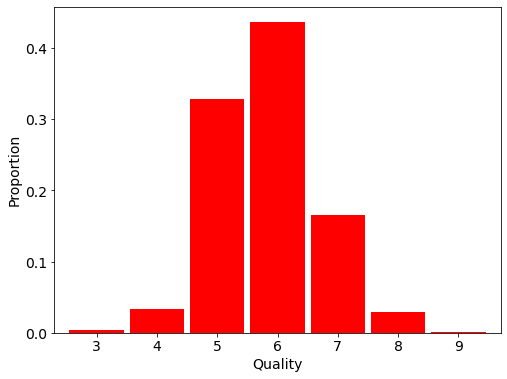

In [6]:
plt.figure(figsize(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Давайте научимся оценивать этот признак, чтобы мы могли заранее предположить, какую оценку получит какое-то новое вино, которого в выборке нет. 
Чтобы смоделировать такую ситуацию, отделим 25% выборки для контроля качества предсказания:

In [63]:
X_train, X_test, y_train, y_test = train_test_split(wine.iloc[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, 
                                                    stratify=wine[['Type', 'quality']])
X_train

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%)
2218,white,7.4,0.19,0.30,1.4,0.057,33.0,135.0,0.99300,3.12,0.50,9.6
3494,white,7.9,0.26,0.33,10.3,0.039,73.0,212.0,0.99690,2.93,0.49,9.5
1173,red,7.6,0.36,0.31,1.7,0.079,26.0,65.0,0.99716,3.46,0.62,9.5
4836,white,6.4,0.23,0.35,4.6,0.039,43.0,147.0,0.99216,3.18,0.40,11.0
1604,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2881,white,7.4,0.31,0.74,10.7,0.039,51.0,147.0,0.99770,3.02,0.43,8.7
5463,white,6.6,0.39,0.22,4.0,0.038,17.0,98.0,0.99018,3.25,0.53,13.0
1959,white,6.4,0.24,0.32,14.9,0.047,54.0,162.0,0.99680,3.28,0.50,10.2
3272,white,6.6,0.27,0.31,5.3,0.137,35.0,163.0,0.99510,3.20,0.38,9.3


In [66]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

In [68]:
X_train

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%)
2218,1,7.4,0.19,0.30,1.4,0.057,33.0,135.0,0.99300,3.12,0.50,9.6
3494,1,7.9,0.26,0.33,10.3,0.039,73.0,212.0,0.99690,2.93,0.49,9.5
1173,-1,7.6,0.36,0.31,1.7,0.079,26.0,65.0,0.99716,3.46,0.62,9.5
4836,1,6.4,0.23,0.35,4.6,0.039,43.0,147.0,0.99216,3.18,0.40,11.0
1604,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2881,1,7.4,0.31,0.74,10.7,0.039,51.0,147.0,0.99770,3.02,0.43,8.7
5463,1,6.6,0.39,0.22,4.0,0.038,17.0,98.0,0.99018,3.25,0.53,13.0
1959,1,6.4,0.24,0.32,14.9,0.047,54.0,162.0,0.99680,3.28,0.50,10.2
3272,1,6.6,0.27,0.31,5.3,0.137,35.0,163.0,0.99510,3.20,0.38,9.3


Если у нас нет больше никакой информации о винах, то наше лучшее предположение об оценке — среднее имеющихся в обучающей выборке:

In [69]:
y_train

2218    6
3494    6
1173    6
4836    7
1604    6
       ..
2881    5
5463    7
1959    6
3272    5
5731    5
Name: quality, Length: 4872, dtype: int64

In [24]:
np.mean(y_train)

5.817733990147783

Если мы будем предсказывать этой величиной оценку всех вин, на обучающей выборке мы получим среднеквадратичную ошибку

In [25]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train))

0.8735940831862377

а на тестовой

In [26]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test))

0.8719705746838052

На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект.

# Тип вина

Какая-то ещё информация у нас есть, например, о типе вина:

In [27]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются:

Text(0.5, 0, 'Quality')

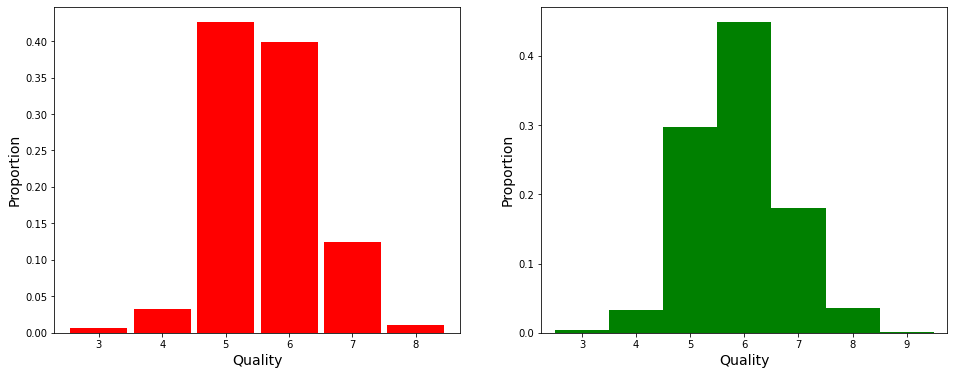

In [31]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(color='g', kind='bar', width=1)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Различие между средними статистически значимо:

In [32]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

4.888069044202246e-22

95% доверительный интервал для разности средних оценок:

In [33]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017958, 0.29084357932805205)

Чтобы уточнить наше предсказание, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке:

In [34]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].values.reshape(-1,1), y_train)

LinearRegression()

In [36]:
y_train_predictions = regressor.predict(X_train['Type'].values.reshape(-1,1))

In [38]:
y_test_predictions = regressor.predict(X_test['Type'].values.reshape(-1,1))

Ошибки предсказания немного уменьшились:

In [39]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.8735940831862377

In [40]:
sqrt(mean_squared_error(y_test_predictions, y_test))

0.8719705746838052

Вот так выглядят истинные оценки вин и их предсказания средними по типам на тестовой выборке:

Text(0, 0.5, 'Estimated quality')

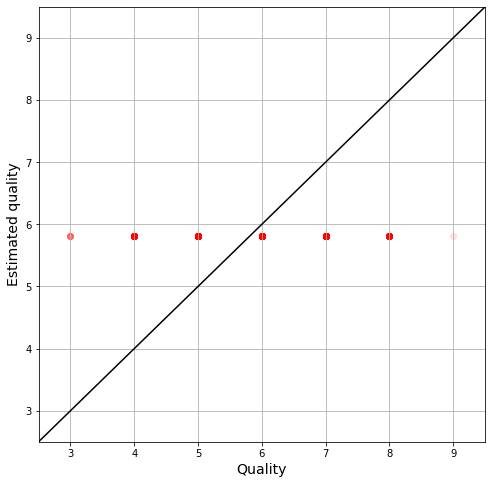

In [41]:
pyplot.figure(figsize(8,8))
pyplot.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

# Другие признаки

На самом деле у нас есть ещё 11 признаков, описывающих химический состав вин:

In [42]:
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
2234,white,5.9,0.140,0.25,4.5,0.027,34.0,140.0,0.99340,3.49,0.51,10.8,6
1842,white,6.8,0.240,0.34,2.7,0.047,64.5,218.5,0.99340,3.30,0.58,9.7,6
5824,white,6.2,0.345,0.27,10.1,0.056,38.0,187.0,0.99486,3.31,0.56,10.6,5
907,red,6.1,0.560,0.00,2.2,0.079,6.0,9.0,0.99480,3.59,0.54,11.5,6
6039,white,6.7,0.340,0.31,16.4,0.051,20.0,146.0,0.99834,3.06,0.54,9.1,5


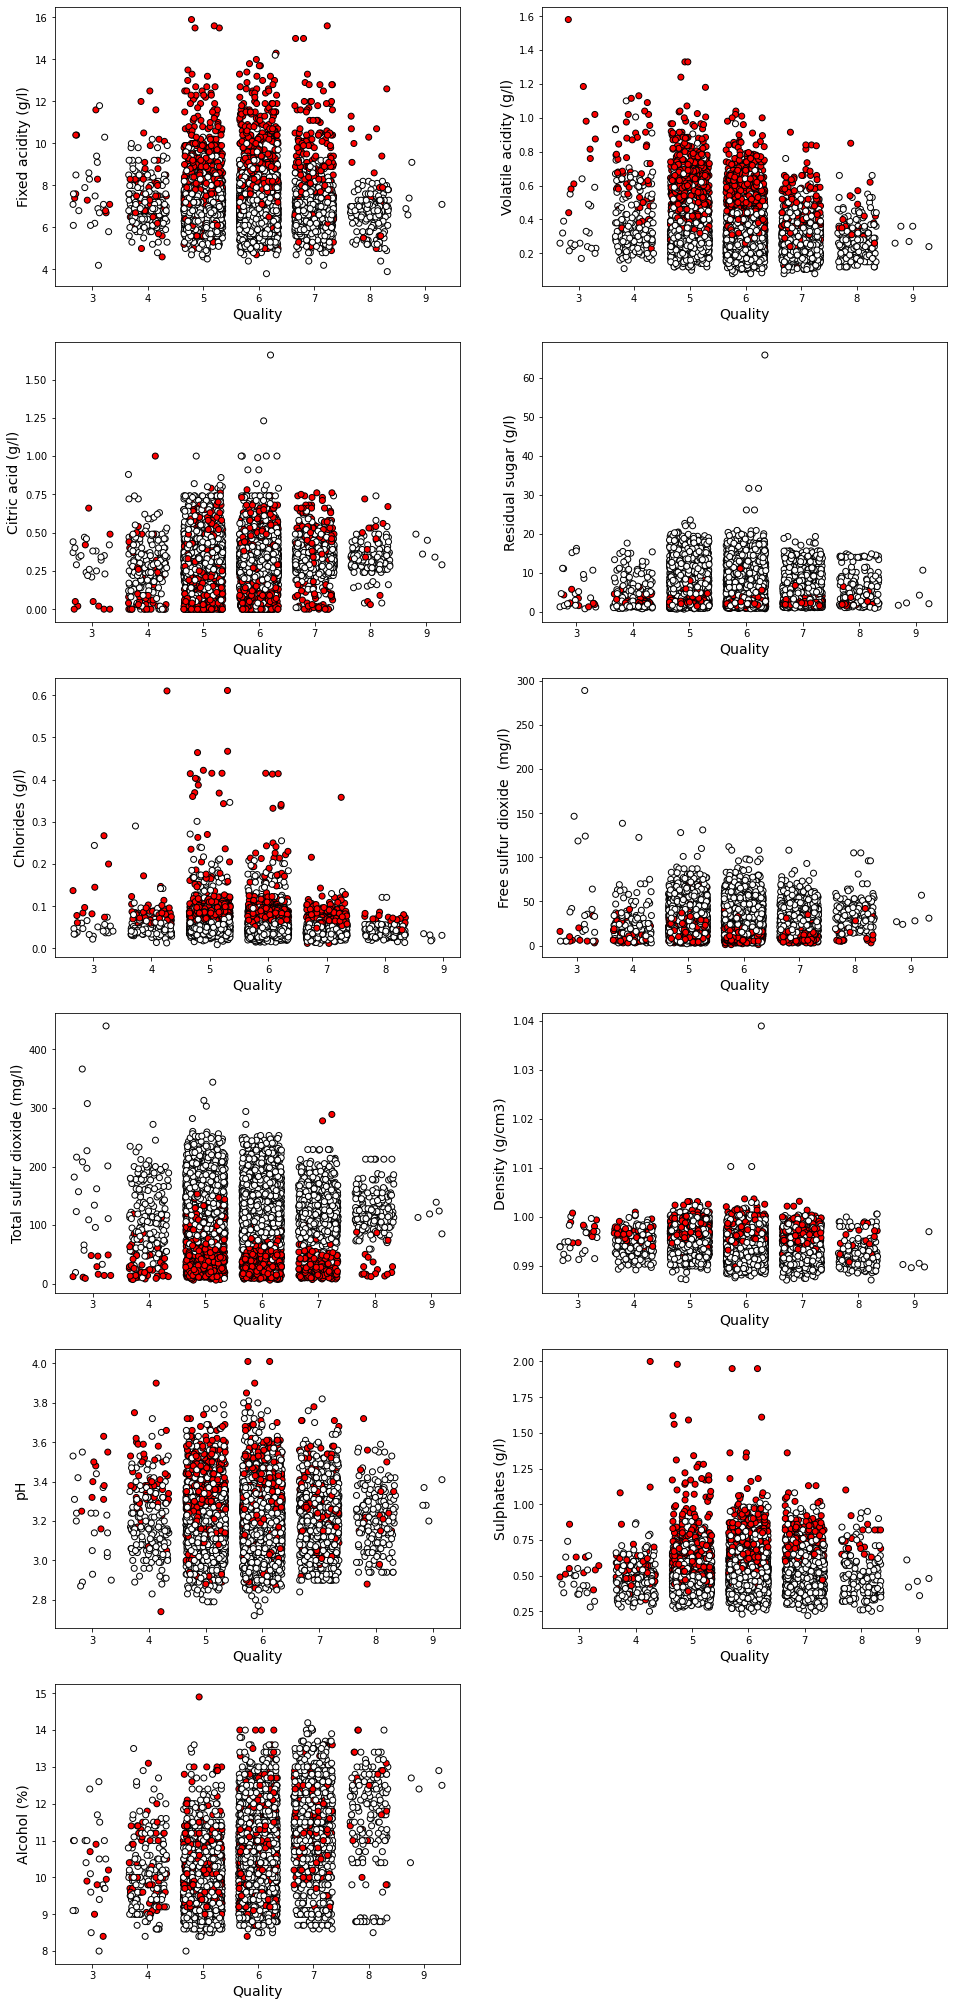

In [44]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, 12):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.iloc[:, i], color=wine["Type"], edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

Попробуем их учесть при построении прогноза оценок.

## Линейная регрессия

Построим для начала линейную регрессионную модель.

In [45]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Ошибки предсказания существенно уменьшились:

In [46]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))

0.7335501300691164

In [47]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.7383323794179653

Истинные оценки вин и их предсказания линейной моделью:

Text(0, 0.5, 'Estimated quality')

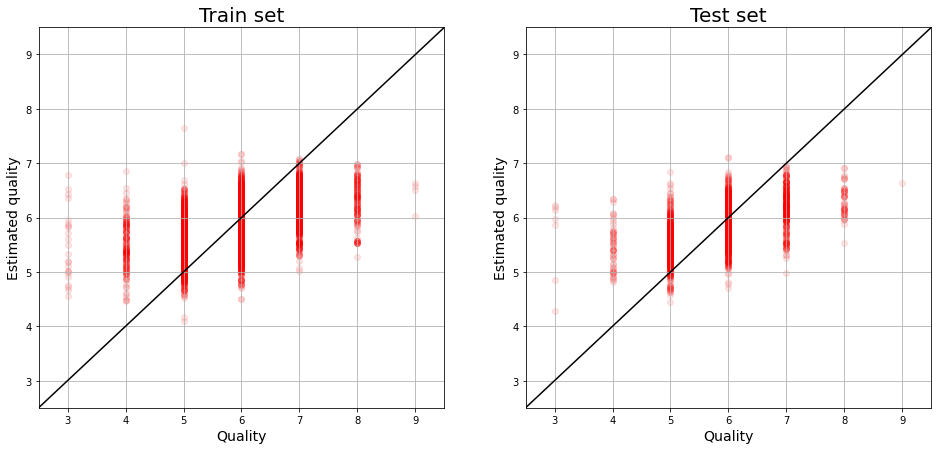

In [48]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Посчитаем коэффициент детерминации — долю объяснённой моделью дисперсии отклика:

In [49]:
lm.score(X_test, y_test)

0.2830250970341094

## Случайный лес

Построим на обучающей выборке случайный лес:

In [50]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

In [51]:
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=3)

Качество выросло ещё сильнее, хотя модель и переобучилась:

In [52]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))

0.34991846484695915

In [53]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.628158000348409

Истинные оценки вин и их предсказания случайным лесом:

Text(0, 0.5, 'Estimated quality')

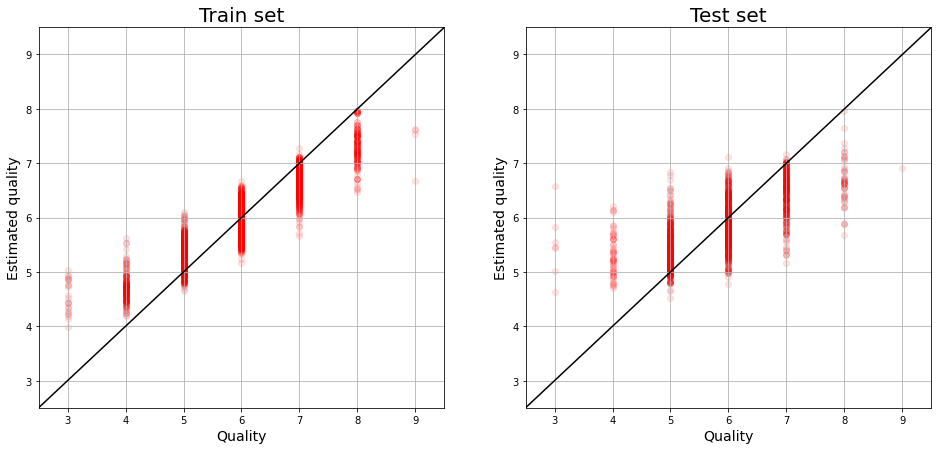

In [54]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Коэффициент детерминации для случайного леса:

In [55]:
rf.score(X_test, y_test)

0.48103518399510925

Сравним ошибки линейной регрессии и случайного леса на тестовой выборке:

Text(0.5, 0, 'Difference of absolute errors')

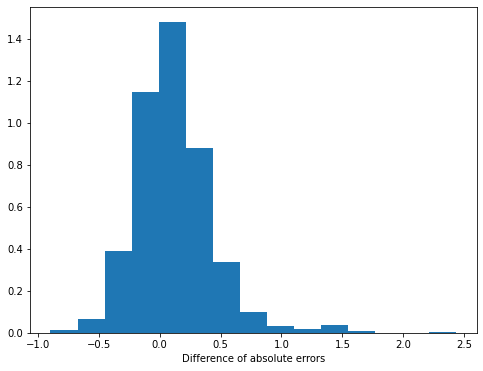

In [57]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, density=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [58]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

7.003683341219415e-13

95% доверительный интервал для средней разности абсолютных ошибок:

In [59]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.08249724101483809, 0.14414279402652766)

То есть, используя вместо линейной регрессии наш случайный лес, мы предсказываем экспертную оценку в среднем на 0.26-0.30 баллов точнее.

Давайте посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [60]:
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.286316
2,Volatile acidity (g/l),0.134943
6,Free sulfur dioxide (mg/l),0.083617
10,Sulphates (g/l),0.075872
7,Total sulfur dioxide (mg/l),0.070969
4,Residual sugar (g/l),0.064934
9,pH,0.061225
3,Citric acid (g/l),0.059602
5,Chlorides (g/l),0.058969
8,Density (g/cm3),0.054652


Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя.